In [126]:
import batoid
import batoid_rubin
import numpy as np
import matplotlib.pyplot as plt
import yaml
import ipywidgets
from pathlib import Path
from tqdm.notebook import tqdm
import galsim
from lsst.ts.ofc import OFC, OFCData, StateEstimator, SensitivityMatrix
import lsst.obs.lsst as obs_lsst
from lsst.afw.cameraGeom import FIELD_ANGLE

%matplotlib inline
%load_ext autoreload
%autoreload 2

ofc_data = OFCData('lsst')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [128]:
from glob import glob
intrinsic_zk_old = dict()
intrinsic_zk_path = ofc_data.config_dir / 'lsst'

for filter_name in ['U', 'G', 'R', 'I', 'Z', 'Y']:
    file_name = f"intrinsicZn{filter_name}*.yaml"
    intrinsic_file = Path(
        glob(str(intrinsic_zk_path / file_name))[0]
    )
    
    with open(intrinsic_file) as fp:
        intrinsic_zk_old[filter_name] = np.array(yaml.safe_load(fp))

In [134]:
with open("/sdf/home/g/gmegias/aos/ts_ofc/policy/gaussian_quadrature_points/lsst/fieldXy.yaml") as fp:
    gq_field_angles = np.array(yaml.safe_load(fp))
    gq_field_angles[:, 0] *= -1

field_x, field_y = zip(*gq_field_angles)
maxs = {}

for filters in ['u', 'g', 'r', 'i', 'z', 'y']:
    evaluated_zernikes = np.array(
        [
            zk.coef for zk in galsim.zernike.DoubleZernike(
                ofc_data.intrinsic_zk[filters],
                # Rubin annuli
                uv_inner=0.0,
                uv_outer=1.75,
                xy_inner=0.612 * 4.18,
                xy_outer=4.18,
            ).rotate(theta_uv=0.0)(field_x, field_y)
        ]
    )

    evaluated_zernikes = evaluated_zernikes[:, 4:23]
    old_zernikes = intrinsic_zk_old[filters.upper()][:, 3:22]

    maxs[filters] = []
    for ifield in range(35):
        maxs[filters].append(np.sum((evaluated_zernikes[ifield, ...]-old_zernikes[ifield, ...])**2)/np.sum(old_zernikes[ifield, ...]**2))


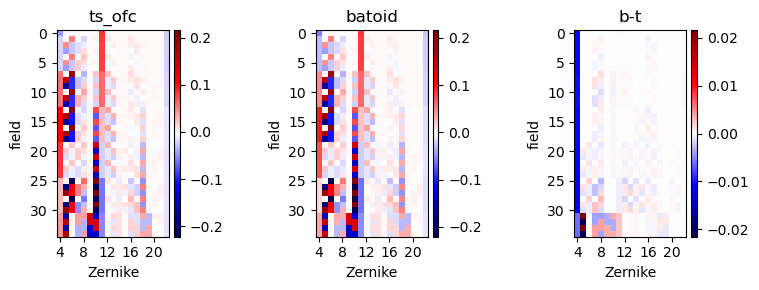

In [131]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(8, 3))
colorbar(axes[0].imshow(old_zernikes, cmap='seismic',))
colorbar(axes[1].imshow(evaluated_zernikes, cmap='seismic',))
colorbar(axes[2].imshow(evaluated_zernikes-old_zernikes, cmap='seismic',))
axes[0].set_title("ts_ofc")
axes[1].set_title("batoid")
axes[2].set_title("b-t")
for ax in axes:
    ax.set_xlabel("Zernike")
    ax.set_ylabel("field")
    ax.set_xticks(np.arange(0,19,4), np.arange(4,23,4))
fig.tight_layout()


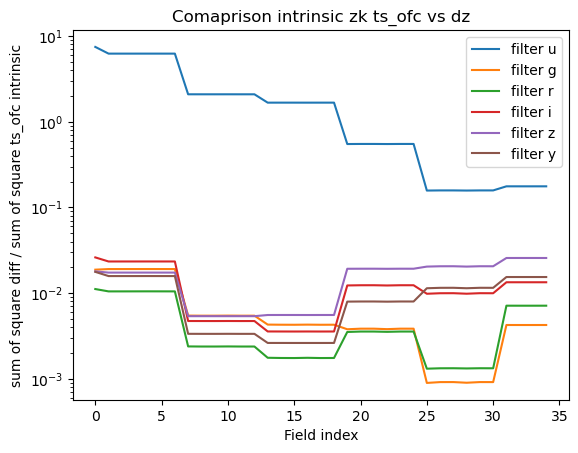

In [139]:
for filters in ['u', 'g', 'r', 'i', 'z', 'y']:
    plt.semilogy(np.arange(35), maxs[filters], label =  f'filter {filters}')

plt.ylabel('sum of square diff / sum of square ts_ofc intrinsic')
plt.xlabel('Field index')
plt.title('Comaprison intrinsic zk ts_ofc vs dz')
plt.legend()